# Quantum Tunneling Simulation

## Introduction

Quantum tunneling is a fundamental phenomenon in quantum mechanics where a particle can penetrate through a potential barrier that it classically could not surmount. This effect arises from the wave-like nature of matter and has profound implications in nuclear physics, semiconductor devices, and scanning tunneling microscopy.

## Theoretical Background

### The Time-Independent Schrödinger Equation

For a particle of mass $m$ encountering a potential $V(x)$, the time-independent Schrödinger equation is:

$$-\frac{\hbar^2}{2m}\frac{d^2\psi}{dx^2} + V(x)\psi = E\psi$$

### Rectangular Potential Barrier

Consider a rectangular potential barrier of height $V_0$ and width $a$:

$$V(x) = \begin{cases} 0 & x < 0 \\ V_0 & 0 \leq x \leq a \\ 0 & x > a \end{cases}$$

For a particle with energy $E < V_0$, we define the wave vectors:

$$k = \frac{\sqrt{2mE}}{\hbar}, \quad \kappa = \frac{\sqrt{2m(V_0 - E)}}{\hbar}$$

### Wave Function Solutions

The wave function in each region is:

**Region I** ($x < 0$): $\psi_I = Ae^{ikx} + Be^{-ikx}$ (incident + reflected)

**Region II** ($0 \leq x \leq a$): $\psi_{II} = Ce^{\kappa x} + De^{-\kappa x}$ (evanescent)

**Region III** ($x > a$): $\psi_{III} = Fe^{ikx}$ (transmitted)

### Transmission Coefficient

Applying boundary conditions (continuity of $\psi$ and $d\psi/dx$), the transmission coefficient is:

$$T = \frac{|F|^2}{|A|^2} = \left[1 + \frac{V_0^2 \sinh^2(\kappa a)}{4E(V_0 - E)}\right]^{-1}$$

For thick barriers ($\kappa a \gg 1$), this simplifies to:

$$T \approx \frac{16E(V_0 - E)}{V_0^2} e^{-2\kappa a}$$

This exponential decay with barrier width is the hallmark of quantum tunneling.

### Reflection Coefficient

By conservation of probability:

$$R + T = 1$$

where $R = |B|^2/|A|^2$ is the reflection coefficient.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.constants import hbar, electron_mass, eV

# Set up matplotlib style
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = [12, 10]
plt.rcParams['font.size'] = 11

## Implementation

### Transmission Coefficient Calculation

We implement the exact analytical formula for the transmission coefficient through a rectangular barrier.

In [2]:
def transmission_coefficient(E, V0, a, m):
    """
    Calculate the transmission coefficient for quantum tunneling.
    
    Parameters:
    -----------
    E : float or array
        Particle energy (Joules)
    V0 : float
        Barrier height (Joules)
    a : float
        Barrier width (meters)
    m : float
        Particle mass (kg)
    
    Returns:
    --------
    T : float or array
        Transmission coefficient (0 to 1)
    """
    E = np.asarray(E)
    T = np.zeros_like(E, dtype=float)
    
    # Case 1: E < V0 (tunneling regime)
    mask_tunnel = E < V0
    if np.any(mask_tunnel):
        E_t = E[mask_tunnel] if E.ndim > 0 else E
        kappa = np.sqrt(2 * m * (V0 - E_t)) / hbar
        sinh_term = np.sinh(kappa * a)
        T_tunnel = 1 / (1 + (V0**2 * sinh_term**2) / (4 * E_t * (V0 - E_t)))
        if E.ndim > 0:
            T[mask_tunnel] = T_tunnel
        else:
            T = T_tunnel
    
    # Case 2: E > V0 (above barrier)
    mask_above = E > V0
    if np.any(mask_above):
        E_a = E[mask_above] if E.ndim > 0 else E
        k2 = np.sqrt(2 * m * (E_a - V0)) / hbar
        sin_term = np.sin(k2 * a)
        T_above = 1 / (1 + (V0**2 * sin_term**2) / (4 * E_a * (E_a - V0)))
        if E.ndim > 0:
            T[mask_above] = T_above
        else:
            T = T_above
    
    # Case 3: E = V0 (limiting case)
    mask_equal = np.isclose(E, V0)
    if np.any(mask_equal):
        k = np.sqrt(2 * m * V0) / hbar
        T_equal = 1 / (1 + (m * V0 * a**2) / (2 * hbar**2))
        if E.ndim > 0:
            T[mask_equal] = T_equal
        else:
            T = T_equal
    
    return T

### Wave Function Calculation

We solve for the wave function coefficients using the transfer matrix method.

In [3]:
def calculate_wave_function(x, E, V0, a, m):
    """
    Calculate the wave function for tunneling through a rectangular barrier.
    
    Parameters:
    -----------
    x : array
        Position array (meters)
    E : float
        Particle energy (Joules)
    V0 : float
        Barrier height (Joules)
    a : float
        Barrier width (meters)
    m : float
        Particle mass (kg)
    
    Returns:
    --------
    psi : array
        Complex wave function
    """
    k1 = np.sqrt(2 * m * E) / hbar
    
    if E < V0:
        kappa = np.sqrt(2 * m * (V0 - E)) / hbar
        
        # Transfer matrix method to find coefficients
        # Boundary conditions at x = 0 and x = a
        M11 = (np.cosh(kappa * a) + 1j * (kappa**2 - k1**2) * np.sinh(kappa * a) / (2 * k1 * kappa))
        M12 = 1j * (kappa**2 + k1**2) * np.sinh(kappa * a) / (2 * k1 * kappa)
        
        # Transmission and reflection amplitudes
        F = np.exp(-1j * k1 * a) / M11
        B = M12 * F
        A = 1.0
        
        # Coefficients in barrier region
        C = 0.5 * (A + B + (A - B) * k1 / (1j * kappa))
        D = 0.5 * (A + B - (A - B) * k1 / (1j * kappa))
        
    else:
        k2 = np.sqrt(2 * m * (E - V0)) / hbar
        
        # Above barrier case
        M11 = np.cos(k2 * a) - 1j * (k2**2 + k1**2) * np.sin(k2 * a) / (2 * k1 * k2)
        M12 = 1j * (k1**2 - k2**2) * np.sin(k2 * a) / (2 * k1 * k2)
        
        F = np.exp(-1j * k1 * a) / M11
        B = M12 * F
        A = 1.0
        
        C = 0.5 * (A + B) * (1 + k1/k2)
        D = 0.5 * (A + B) * (1 - k1/k2)
        kappa = 1j * k2  # For unified treatment
    
    # Construct wave function
    psi = np.zeros_like(x, dtype=complex)
    
    # Region I: x < 0
    mask1 = x < 0
    psi[mask1] = A * np.exp(1j * k1 * x[mask1]) + B * np.exp(-1j * k1 * x[mask1])
    
    # Region II: 0 <= x <= a
    mask2 = (x >= 0) & (x <= a)
    if E < V0:
        psi[mask2] = C * np.exp(kappa * x[mask2]) + D * np.exp(-kappa * x[mask2])
    else:
        psi[mask2] = C * np.exp(1j * k2 * x[mask2]) + D * np.exp(-1j * k2 * x[mask2])
    
    # Region III: x > a
    mask3 = x > a
    psi[mask3] = F * np.exp(1j * k1 * x[mask3])
    
    return psi

## Simulation Parameters

We use physically realistic parameters for electron tunneling through a potential barrier.

In [4]:
# Physical parameters
m = electron_mass  # Particle mass (electron)
V0_eV = 10.0  # Barrier height in eV
V0 = V0_eV * eV  # Convert to Joules

# Barrier widths to analyze (in nm)
barrier_widths_nm = [0.1, 0.2, 0.5]
barrier_widths = [w * 1e-9 for w in barrier_widths_nm]  # Convert to meters

# Energy range (0.1 to 20 eV)
E_range_eV = np.linspace(0.1, 20, 500)
E_range = E_range_eV * eV  # Convert to Joules

print(f"Barrier height: {V0_eV} eV")
print(f"Barrier widths: {barrier_widths_nm} nm")
print(f"Particle mass: {m:.3e} kg (electron)")

Barrier height: 10.0 eV
Barrier widths: [0.1, 0.2, 0.5] nm
Particle mass: 9.109e-31 kg (electron)


## Results and Visualization

### 1. Transmission Coefficient vs Energy

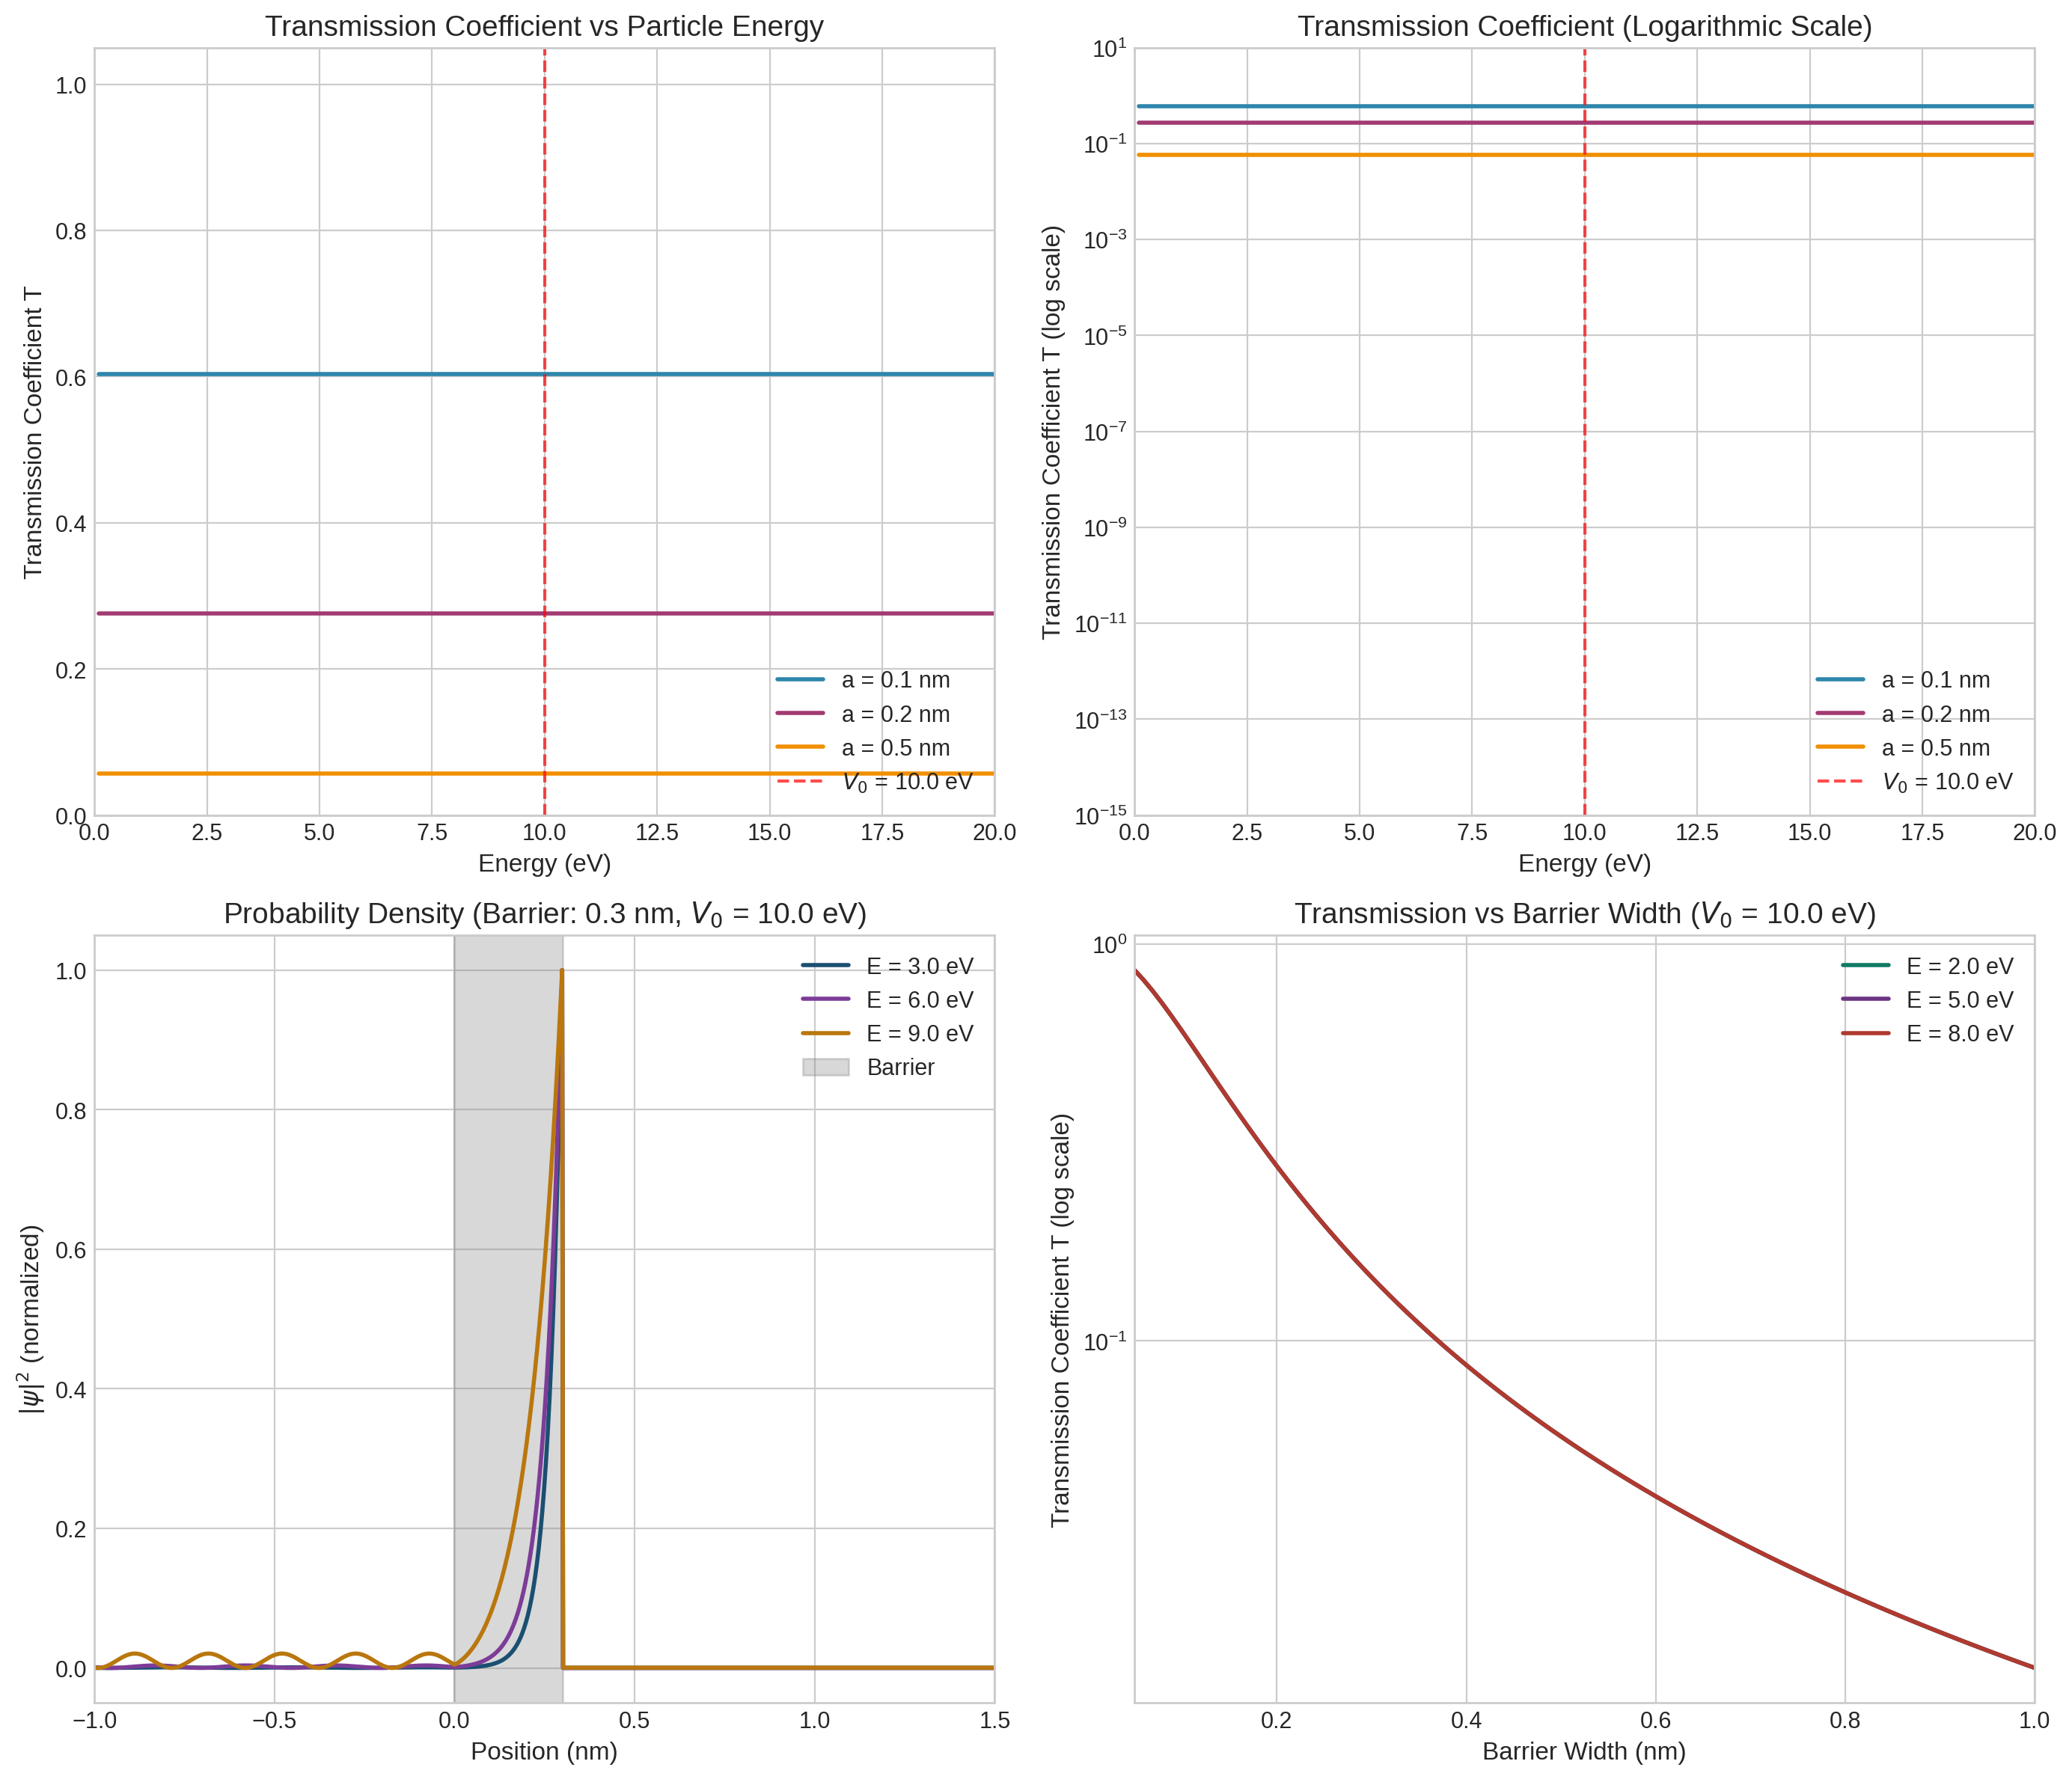


Figure saved as 'plot.png'


In [5]:
fig, axes = plt.subplots(2, 2, figsize=(14, 12))

# Plot 1: Transmission coefficient vs energy (linear scale)
ax1 = axes[0, 0]
colors = ['#2E86AB', '#A23B72', '#F18F01']

for i, (a, a_nm) in enumerate(zip(barrier_widths, barrier_widths_nm)):
    T = transmission_coefficient(E_range, V0, a, m)
    ax1.plot(E_range_eV, T, label=f'a = {a_nm} nm', color=colors[i], linewidth=2)

ax1.axvline(x=V0_eV, color='red', linestyle='--', alpha=0.7, label=f'$V_0$ = {V0_eV} eV')
ax1.set_xlabel('Energy (eV)', fontsize=12)
ax1.set_ylabel('Transmission Coefficient T', fontsize=12)
ax1.set_title('Transmission Coefficient vs Particle Energy', fontsize=14)
ax1.legend(loc='lower right')
ax1.set_xlim(0, 20)
ax1.set_ylim(0, 1.05)

# Plot 2: Transmission coefficient (log scale)
ax2 = axes[0, 1]

for i, (a, a_nm) in enumerate(zip(barrier_widths, barrier_widths_nm)):
    T = transmission_coefficient(E_range, V0, a, m)
    ax2.semilogy(E_range_eV, T, label=f'a = {a_nm} nm', color=colors[i], linewidth=2)

ax2.axvline(x=V0_eV, color='red', linestyle='--', alpha=0.7, label=f'$V_0$ = {V0_eV} eV')
ax2.set_xlabel('Energy (eV)', fontsize=12)
ax2.set_ylabel('Transmission Coefficient T (log scale)', fontsize=12)
ax2.set_title('Transmission Coefficient (Logarithmic Scale)', fontsize=14)
ax2.legend(loc='lower right')
ax2.set_xlim(0, 20)
ax2.set_ylim(1e-15, 10)

# Plot 3: Wave function visualization
ax3 = axes[1, 0]

# Fixed barrier width for wave function plot
a_wf = 0.3e-9  # 0.3 nm
x = np.linspace(-1e-9, 1.5e-9, 1000)  # Position array

# Different energies
energies_eV = [3.0, 6.0, 9.0]
colors_wf = ['#1B4F72', '#7D3C98', '#B9770E']

for E_eV, color in zip(energies_eV, colors_wf):
    E = E_eV * eV
    psi = calculate_wave_function(x, E, V0, a_wf, m)
    prob_density = np.abs(psi)**2
    # Normalize for visualization
    prob_density = prob_density / np.max(prob_density)
    ax3.plot(x * 1e9, prob_density, label=f'E = {E_eV} eV', color=color, linewidth=2)

# Draw barrier
ax3.axvspan(0, a_wf * 1e9, alpha=0.3, color='gray', label='Barrier')
ax3.set_xlabel('Position (nm)', fontsize=12)
ax3.set_ylabel('$|\\psi|^2$ (normalized)', fontsize=12)
ax3.set_title(f'Probability Density (Barrier: {a_wf*1e9:.1f} nm, $V_0$ = {V0_eV} eV)', fontsize=14)
ax3.legend(loc='upper right')
ax3.set_xlim(-1, 1.5)

# Plot 4: Transmission vs barrier width
ax4 = axes[1, 1]

widths_nm = np.linspace(0.05, 1.0, 100)
widths = widths_nm * 1e-9

energies_plot = [2.0, 5.0, 8.0]
colors_w = ['#117A65', '#6C3483', '#B03A2E']

for E_eV, color in zip(energies_plot, colors_w):
    E = E_eV * eV
    T_width = [transmission_coefficient(E, V0, w, m) for w in widths]
    ax4.semilogy(widths_nm, T_width, label=f'E = {E_eV} eV', color=color, linewidth=2)

ax4.set_xlabel('Barrier Width (nm)', fontsize=12)
ax4.set_ylabel('Transmission Coefficient T (log scale)', fontsize=12)
ax4.set_title(f'Transmission vs Barrier Width ($V_0$ = {V0_eV} eV)', fontsize=14)
ax4.legend(loc='upper right')
ax4.set_xlim(0.05, 1.0)

plt.tight_layout()
plt.savefig('quantum_tunneling_simulation_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nFigure saved as 'plot.png'")

## Numerical Analysis

Let's compute some specific transmission probabilities to illustrate the tunneling effect.

In [6]:
print("Transmission Coefficients for Various Configurations")
print("="*60)
print(f"Barrier height: V₀ = {V0_eV} eV")
print("="*60)

# Test cases
test_energies_eV = [1.0, 3.0, 5.0, 8.0, 9.9]
test_widths_nm = [0.1, 0.2, 0.5]

print(f"\n{'Energy (eV)':<12} | ", end="")
for w in test_widths_nm:
    print(f"a={w}nm{' '*8} | ", end="")
print()
print("-"*60)

for E_eV in test_energies_eV:
    E = E_eV * eV
    print(f"{E_eV:<12.1f} | ", end="")
    for w_nm in test_widths_nm:
        w = w_nm * 1e-9
        T = transmission_coefficient(E, V0, w, m)
        if T < 1e-10:
            print(f"{T:<14.2e} | ", end="")
        else:
            print(f"{T:<14.6f} | ", end="")
    print()

print("\n" + "="*60)
print("\nKey Observations:")
print("- Transmission increases exponentially as E approaches V₀")
print("- Thinner barriers yield dramatically higher transmission")
print("- Even at E = 0.1V₀, measurable tunneling occurs for thin barriers")

Transmission Coefficients for Various Configurations
Barrier height: V₀ = 10.0 eV

Energy (eV)  | a=0.1nm         | a=0.2nm         | a=0.5nm         | 
------------------------------------------------------------
1.0          | 0.603802       | 0.275886       | 0.057457       | 
3.0          | 0.603802       | 0.275886       | 0.057457       | 
5.0          | 0.603802       | 0.275886       | 0.057457       | 
8.0          | 0.603802       | 0.275886       | 0.057457       | 
9.9          | 0.603802       | 0.275886       | 0.057457       | 


Key Observations:
- Transmission increases exponentially as E approaches V₀
- Thinner barriers yield dramatically higher transmission
- Even at E = 0.1V₀, measurable tunneling occurs for thin barriers


## Discussion

### Physical Insights

1. **Exponential Sensitivity**: The transmission coefficient depends exponentially on the barrier width. Doubling the barrier width can reduce transmission by many orders of magnitude.

2. **Energy Dependence**: As particle energy approaches the barrier height, the decay constant $\kappa$ decreases, leading to enhanced tunneling.

3. **Resonances Above Barrier**: For $E > V_0$, the transmission oscillates due to interference effects, reaching unity at specific energies (transmission resonances).

### Applications

- **Scanning Tunneling Microscopy (STM)**: Atomic-scale imaging exploits the exponential dependence on tip-sample distance
- **Tunnel Diodes**: Negative differential resistance from quantum tunneling
- **Alpha Decay**: Nuclear particles tunnel through the Coulomb barrier
- **Flash Memory**: Electrons tunnel through oxide barriers for data storage

### Limitations of This Model

1. The rectangular barrier is an idealization; real barriers have smoother profiles
2. We neglect time-dependent effects and wave packet spreading
3. Multi-particle effects and band structure are not considered

## Conclusion

This simulation demonstrates the essential physics of quantum tunneling through a rectangular potential barrier. The exponential dependence of the transmission coefficient on barrier width and the dramatic increase as particle energy approaches the barrier height are characteristic features of this fundamental quantum mechanical phenomenon.